In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow
import mlflow.sklearn

In [3]:
import os
import librosa
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    RocCurveDisplay
)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier





import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from joblib import Parallel, delayed



from utils import load_config
from models.baseline import preprocess_data

In [5]:
config       = load_config()
features_dir = config['data_paths']['features']
features_csv = os.path.join(features_dir, 'all_features.csv')

### Load features

In [6]:
features_df = pd.read_csv(features_csv)
features_df.head()

,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_25th_percentile,spectral_centroid_50th_percentile,...,shimmer_dda,hnr,voicedcount,npause,originaldur,intensity_duration,speakingrate,articulationrate,asd,totalpauseduration
0,LJ028-0143,WF1,1874.133940,1345.530923,1.810453e+06,526.534014,6285.029512,5758.495498,975.050304,1345.562364,...,0.099888,11.673236,32.0,2.0,7.360726,7.360726,4.347397,4.925558,0.203023,0.864
1,LJ028-0143,WF2,1896.024231,1357.514810,1.842846e+06,585.883222,6304.308256,5718.425035,985.413912,1390.383399,...,0.096005,12.024721,29.0,2.0,7.360726,7.360726,3.939829,4.463787,0.224025,0.864
2,LJ028-0143,WF3,1918.827899,1370.524166,1.878336e+06,550.249874,6265.837711,5715.587837,1007.631444,1414.627604,...,0.111386,11.691639,30.0,2.0,7.349116,7.349116,4.082124,4.614593,0.216704,0.848
3,LJ028-0143,WF4,1871.877706,1335.658077,1.783982e+06,515.918819,6277.746003,5761.827184,974.725797,1356.723998,...,0.088301,12.341544,33.0,2.0,7.360726,7.360726,4.483254,5.079482,0.196870,0.864
4,LJ028-0143,WF5,1939.824198,1358.239585,1.844815e+06,555.707767,6259.423582,5703.715815,1010.880341,1418.982549,...,0.109853,11.311680,32.0,2.0,7.360726,7.360726,4.347397,4.925558,0.203023,0.864


In [7]:
selected_features = ['spectral_contrast_var', 'spectral_contrast_range', 'spectral_contrast_mean', 'F3_mean', 'F2_stdev', 'F3_stdev', 'F1_stdev', 'mfcc_13_std', 'F2_mean', 'mfcc_6_75th_percentile', 'mfcc_12_75th_percentile', 'mfcc_9_75th_percentile', 'mfcc_3_75th_percentile', 'mfcc_12_50th_percentile', 'mfcc_9_50th_percentile', 'mfcc_2_50th_percentile', 'mfcc_5_50th_percentile', 'mfcc_7_50th_percentile', 'f0_skew', 'pause_std', 'asd', 'pause_75th_percentile', 'chroma_11_50th_percentile', 'chroma_3_50th_percentile', 'chroma_6_50th_percentile', 'spectral_flux_skew', 'mfcc_12_25th_percentile', 'mfcc_6_25th_percentile', 'mfcc_2_25th_percentile', 'spectral_bandwidth_min', 'zero_crossing_rate_skew', 'chroma_1_range', 'speaking_rate', 'chroma_12_range', 'chroma_2_range', 'chroma_3_range', 'chroma_5_range', 'chroma_10_range', 'spectral_flatness_skew', 'chroma_6_range', 'chroma_8_range', 'chroma_7_range', 'chroma_9_range', 'f0_kurtosis', 'chroma_11_range', 'spectral_bandwidth_kurtosis', 'chroma_6_max', 'chroma_10_max', 'chroma_2_max', 'chroma_12_max', 'chroma_5_max', 'chroma_7_max', 'chroma_4_max', 'chroma_1_max', 'chroma_11_max', 'chroma_4_std', 'chroma_6_std', 'chroma_7_std', 'chroma_3_max', 'chroma_12_std', 'chroma_11_std', 'chroma_2_std', 'chroma_10_std', 'chroma_3_std', 'chroma_9_std', 'chroma_8_std', 'chroma_5_std', 'chroma_1_std', 'zero_crossing_rate_range', 'mfcc_1_skew', 'spectral_rolloff_range', 'f0_25th_percentile', 'pause_skew', 'chroma_9_min', 'mfcc_13_mean', 'mfcc_11_mean', 'zero_crossing_rate_min', 'spectral_bandwidth_max', 'mfcc_10_max', 'f0_75th_percentile', 'mfcc_5_max', 'mfcc_6_mean', 'mfcc_3_max', 'jitter_local', 'spectral_flux_25th_percentile', 'spectral_flatness_min', 'energy_min', 'shimmer_local', 'spectral_flatness_range']
features_df = features_df[['audio_id'] + selected_features + ['real_or_fake']].copy()
features_df.loc[:, 'target'] = features_df['real_or_fake'].apply(lambda x: 0 if x == 'R' else 1)

In [8]:
mlflow.set_tracking_uri("http://mlflow:5001")

In [9]:
mlflow.set_experiment('model_training')

<Experiment: artifact_location='mlflow-artifacts:/213449315161875335', creation_time=1723415957368, experiment_id='213449315161875335', last_update_time=1723415957368, lifecycle_stage='active', name='model_training', tags={}>

In [11]:
features_columns = [col for col in features_df.columns if col not in ['audio_id', 'real_or_fake', 'target']]
X = features_df[features_columns]
X = preprocess_data(X)
y = features_df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train.shape, X_test.shape

((280702, 89), (70176, 89))

In [13]:
def train_eval_model(model, model_name, X_train, X_test, y_train, y_test):
    run_name = f"{model_name}_run"
    with mlflow.start_run(run_name=run_name):
        # Log model name
        mlflow.log_param("model", model_name)

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions and evaluate the model
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, probabilities)

        # Log metrics
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc
        })

        # Save and log classification report as text file
        report = classification_report(y_test, predictions)
        with open("classification_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact("classification_report.txt")

        # Plot and log confusion matrix as an image
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        confusion_matrix_path = "confusion_matrix.png"
        plt.savefig(confusion_matrix_path)
        mlflow.log_artifact(confusion_matrix_path)
        plt.close()

        # Plot ROC curve
        fig, ax = plt.subplots()
        RocCurveDisplay.from_predictions(y_test, probabilities, ax=ax)
        plt.title('ROC Curve')
        mlflow.log_figure(fig, "roc_curve.png")
        plt.close(fig)

        print(f"Run Name: {run_name} | Model: {model_name} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f} | ROC AUC: {roc_auc:.4f}")


In [14]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
train_eval_model(log_reg, "Logistic_Regression", X_train, X_test, y_train, y_test)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
train_eval_model(random_forest, "Random_Forest", X_train, X_test, y_train, y_test)

2024/08/11 23:17:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic_Regression_run at: http://mlflow:5001/#/experiments/213449315161875335/runs/84c2e6805e1144f682b2cefc452b1c50.
2024/08/11 23:17:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/213449315161875335.


Run Name: Logistic_Regression_run | Model: Logistic_Regression | Accuracy: 0.9215 | Precision: 0.9400 | Recall: 0.9710 | F1 Score: 0.9552 | ROC AUC: 0.9511


2024/08/11 23:21:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest_run at: http://mlflow:5001/#/experiments/213449315161875335/runs/3a94e5e16b3448f6bf496ae7904af5d5.
2024/08/11 23:21:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow:5001/#/experiments/213449315161875335.


Run Name: Random_Forest_run | Model: Random_Forest | Accuracy: 0.9223 | Precision: 0.9313 | Recall: 0.9823 | F1 Score: 0.9561 | ROC AUC: 0.9529


### Model performance of Logistic Regression

In [16]:
# Name of the experiment
experiment_name = "model_training"

# Get the experiment object
experiment = mlflow.get_experiment_by_name(experiment_name)

# Search for logistic regression runs in the experiment
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.mlflow.runName = 'Logistic_Regression_run'",
    order_by=["start_time desc"],
    max_results=1
)

# Extract the latest run_id
latest_run_id = runs.iloc[0]['run_id'] if not runs.empty else None

latest_run_id

'84c2e6805e1144f682b2cefc452b1c50'

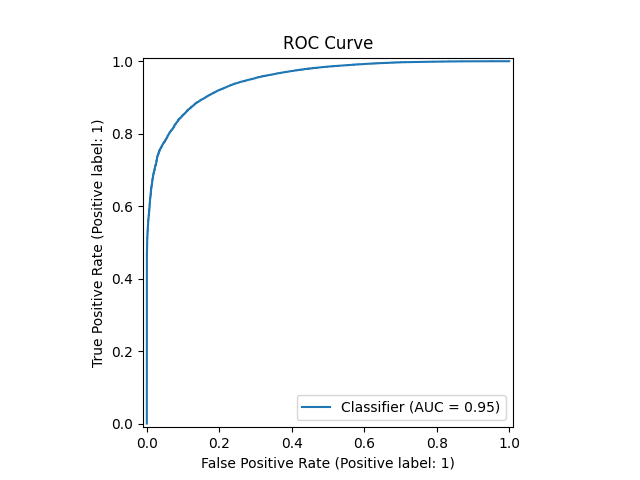

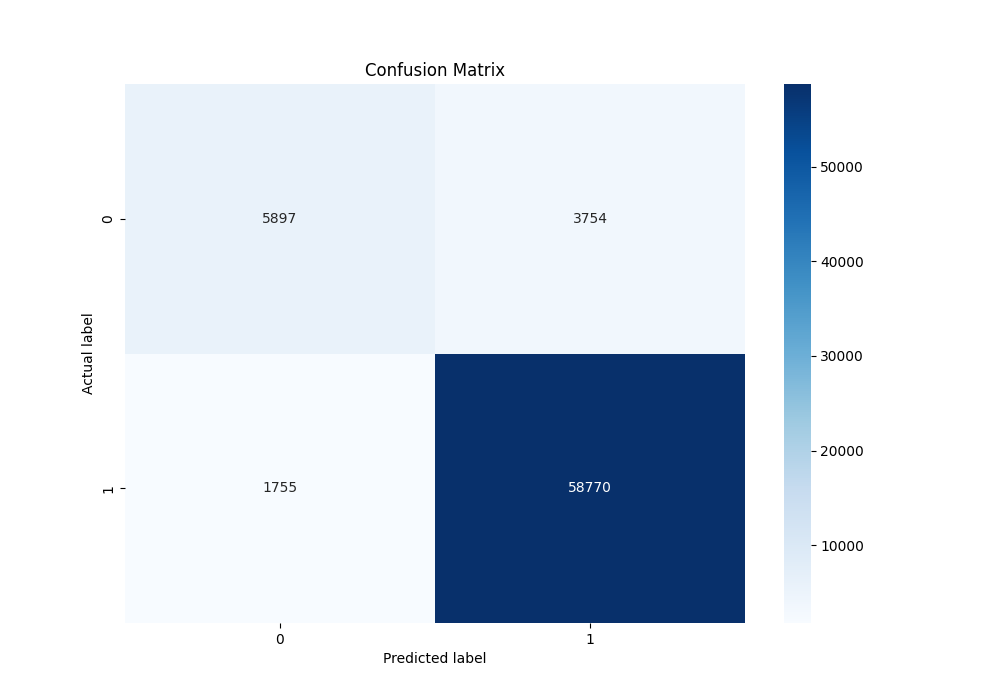

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.61      0.68      9651
           1       0.94      0.97      0.96     60525

    accuracy                           0.92     70176
   macro avg       0.86      0.79      0.82     70176
weighted avg       0.92      0.92      0.92     70176



In [24]:
from IPython.display import display, Image
import os

roc_curve_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/roc_curve.png'
confusion_matrix_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/confusion_matrix.png'
classification_report_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/classification_report.txt'

# Display ROC Curve Image
if os.path.exists(roc_curve_path):
    display(Image(filename=roc_curve_path))
else:
    print("ROC Curve image not found.")

# Display Confusion Matrix Image
if os.path.exists(confusion_matrix_path):
    display(Image(filename=confusion_matrix_path))
else:
    print("Confusion Matrix image not found.")

# Print the Classification Report
if os.path.exists(classification_report_path):
    with open(classification_report_path, 'r') as file:
        classification_report = file.read()
        print("Classification Report:\n", classification_report)
else:
    print("Classification report not found.")


### Model Performance of Random Forest Classifier

In [25]:
# Name of the experiment
experiment_name = "model_training"

# Get the experiment object
experiment = mlflow.get_experiment_by_name(experiment_name)

# Search for logistic regression runs in the experiment
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.mlflow.runName = 'Random_Forest_run'",
    order_by=["start_time desc"],
    max_results=1
)

# Extract the latest run_id
latest_run_id = runs.iloc[0]['run_id'] if not runs.empty else None

latest_run_id

'3a94e5e16b3448f6bf496ae7904af5d5'

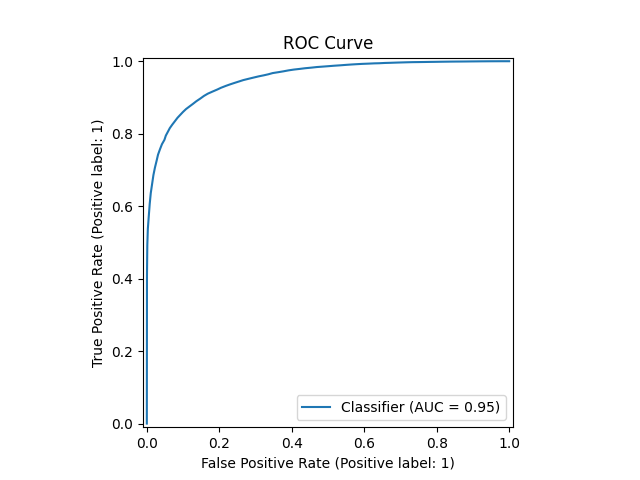

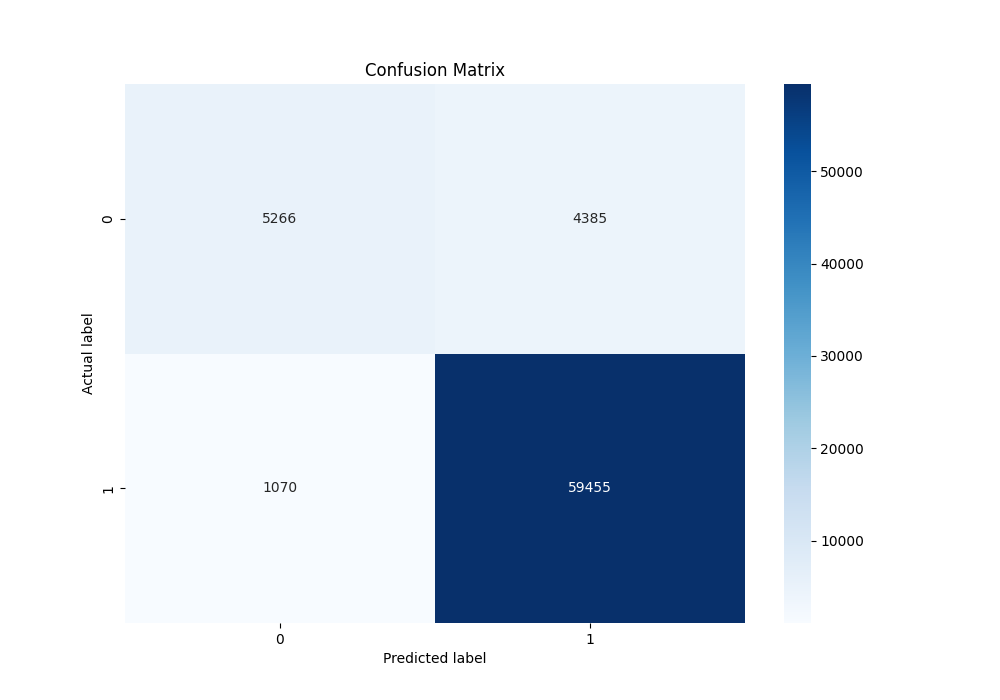

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.55      0.66      9651
           1       0.93      0.98      0.96     60525

    accuracy                           0.92     70176
   macro avg       0.88      0.76      0.81     70176
weighted avg       0.92      0.92      0.92     70176



In [26]:
from IPython.display import display, Image
import os

roc_curve_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/roc_curve.png'
confusion_matrix_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/confusion_matrix.png'
classification_report_path = f'/app/mlartifacts/{experiment.experiment_id}/{latest_run_id}/artifacts/classification_report.txt'

# Display ROC Curve Image
if os.path.exists(roc_curve_path):
    display(Image(filename=roc_curve_path))
else:
    print("ROC Curve image not found.")

# Display Confusion Matrix Image
if os.path.exists(confusion_matrix_path):
    display(Image(filename=confusion_matrix_path))
else:
    print("Confusion Matrix image not found.")

# Print the Classification Report
if os.path.exists(classification_report_path):
    with open(classification_report_path, 'r') as file:
        classification_report = file.read()
        print("Classification Report:\n", classification_report)
else:
    print("Classification report not found.")
